In [1]:
import os
import sys
sys.path.append('../')
from datasets.common_ds import GAN_COMMON_DS, get_common_transform

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [2]:
data_root = '/data/medical/cardiac/cta2mbf/data_114_20210318/5.mbf_myocardium'

In [3]:
transform = get_common_transform([320,320,260],'GAN')
ds = GAN_COMMON_DS(data_root, 'cropped_cta.nii.gz', 'cropped_mbf.nii.gz', [192,320,320], transform)

In [4]:
dataloader = DataLoader(ds, batch_size=2)

In [5]:
# for index, (src_images, dst_images) in enumerate(dataloader):
#     print(src_images)

In [6]:
# one_subject = ds[1]

In [7]:
# ds.__getitem__(0)

0


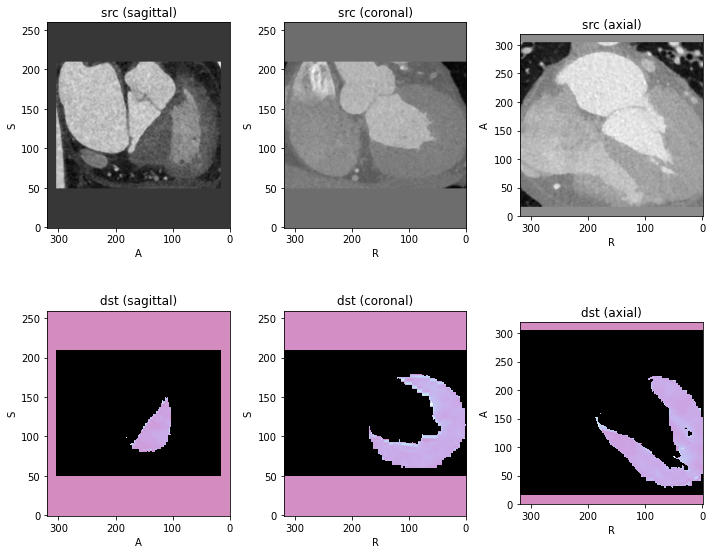

In [8]:
for i in range(ds.__len__()):
    print(i)
    one_subject = ds[0]
    one_subject.plot(figsize=(10,10))
    break

In [13]:
import matplotlib.pyplot as plt
import numpy as np

In [20]:
img_gray = np.random.rand(224,224)
img_jet = plt.get_cmap('jet')(img_gray)

img_jet.shape

# plt.figure(figsize=(10,10))
# plt.subplot(1,2,1)
# plt.imshow(img_gray, cmap='gray')
# plt.subplot(1,2,2)
# plt.imshow(img_jet)

(224, 224, 4)

## 通用医学图像增强

该预处理步骤用于成对数据，如分割任务和生成任务

---
### 先看一下整体效果

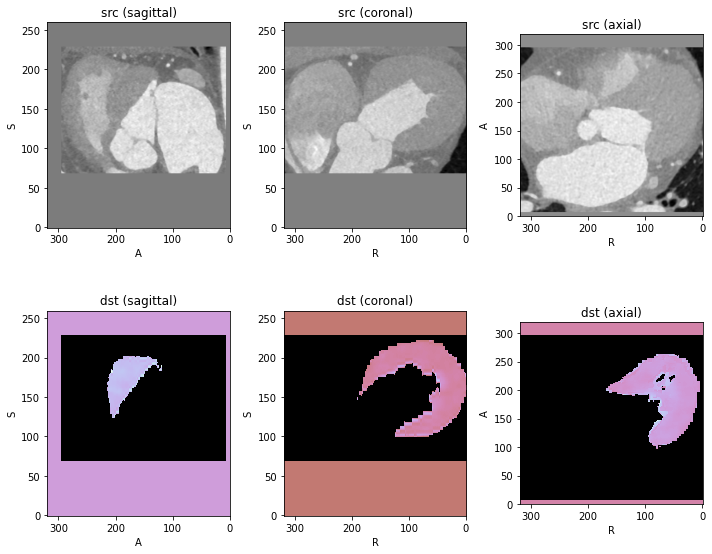

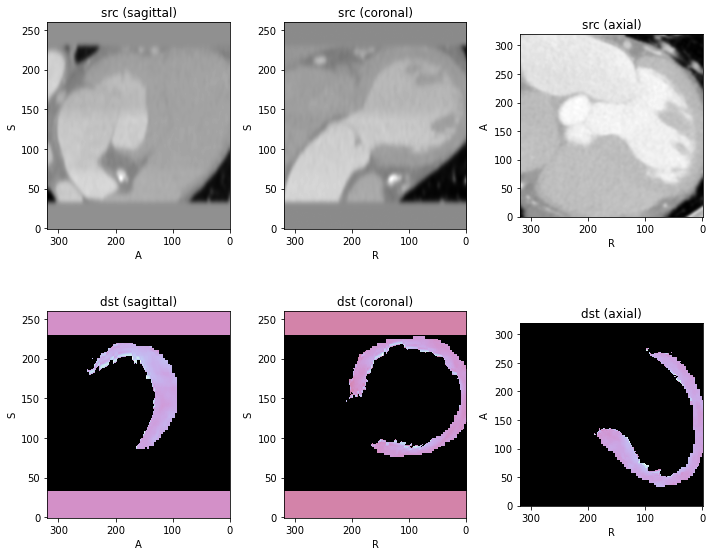

In [16]:
sys.path.append('../external_lib/torchio')

import torchio as tio


image_shape = [320,320,260]


default_transform = tio.Compose([
            tio.RandomFlip(axes=[0,1,2]), 
            tio.RandomAnisotropy(downsampling=(1,2.5),scalars_only=False,p=0.25),              # make images look anisotropic 25% of times
            tio.OneOf({                                # either
                tio.RandomCropOrPad((image_shape[0], image_shape[1], image_shape[2])): 0.8,
                tio.CropOrPad((image_shape[0], image_shape[1], image_shape[2])):0.2,   # or random elastic deformation
            }),
            tio.RandomBlur(p=0.25),                    # blur 25% of times
            tio.RandomNoise(p=0.25)
        ])

ds = GAN_COMMON_DS(data_root, 'cropped_cta.nii.gz', 'cropped_mbf.nii.gz', [192,320,320], default_transform)
dataloader = DataLoader(ds, batch_size=2)

for i in range(2):
    one_subject = ds[i]
    one_subject.plot(figsize=(10,10))

接下来我们分开看每种增强的效果
----
### 1. 随机翻转

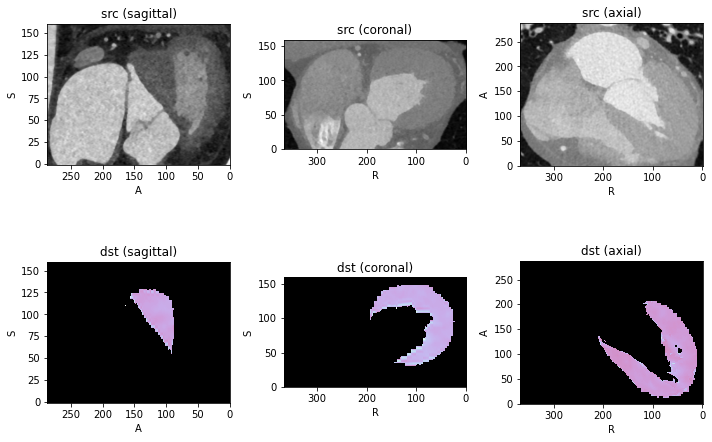

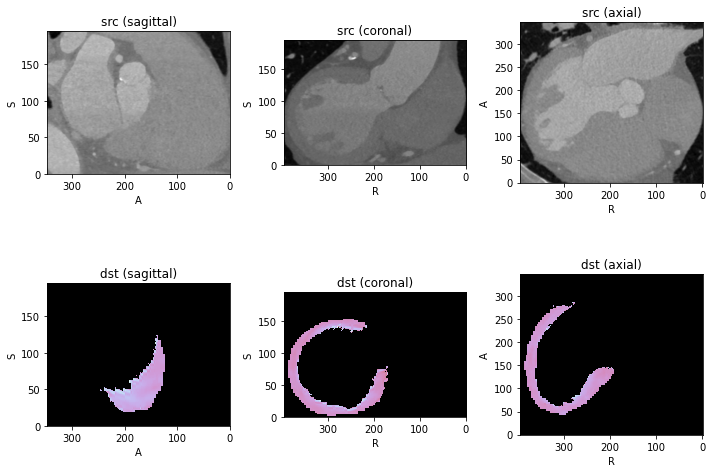

In [6]:
sys.path.append('../external_lib/torchio')

import torchio as tio


image_shape = [320,320,260]
# anisotropy
default_transform = tio.Compose([
            tio.RandomFlip(axes=[0,1,2]), 
        ]) 

ds = GAN_COMMON_DS(data_root, 'cropped_cta.nii.gz', 'cropped_mbf.nii.gz', [192,320,320], default_transform)
dataloader = DataLoader(ds, batch_size=2)

for i in range(2):
    one_subject = ds[i]
    one_subject.plot(figsize=(10,10))

---
### 2. 随机的对数据进行重采样
这里只测试了降采样，用到的类`RandomAnisotropy`，参数及解释如下:

```
Args:
    axes: Axis or tuple of axes along which the image will be downsampled.
    downsampling: Downsampling factor :math:`m \gt 1`. If a tuple
        :math:`(a, b)` is provided then :math:`m \sim \mathcal{U}(a, b)`.
    image_interpolation: Image interpolation used to upsample the image
        back to its initial spacing. Downsampling is performed using
        nearest neighbor interpolation. See :ref:`Interpolation` for
        supported interpolation types.
    scalars_only: Apply only to instances of :class:`torchio.ScalarImage`.
        This is useful when the segmentation quality needs to be kept,
        as in `Billot et al. <billot>`_.
    **kwargs: See :class:`~torchio.transforms.Transform` for additional
        keyword arguments.
```

本例中`tio.RandomAnisotropy(downsampling=(1,2),scalars_only=False, p=0.9999)`

`scalars_only`的设置为True时，则只有`torchio.ScalarImage`数据会进行`RandomAnisotropy`操作。在分割试验中，原始图像我们可以认为是`torchio.ScalarImage`类型的，一般label是`torchio.LabelMap`类型的，若`scalars_only`的设置为True时，则label不会进行`RandomAnisotropy`操作，这会引起误差，这里建议设成True

`downsampling=(1,2)`代表了降采样的倍率在1-2中随机选取

`axes`采用了默认值，则代表在所有的轴中随机选取轴，进行`RandomAnisotropy`操作
`p=0.9999`,代表了该操作执行的概率

0


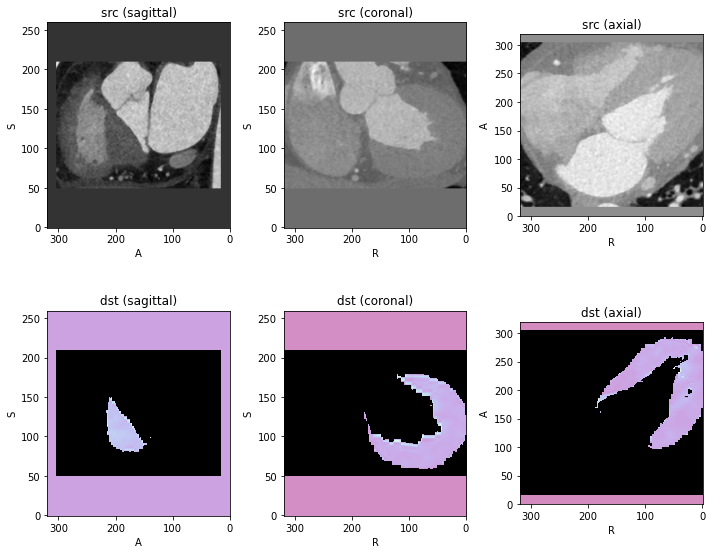

1


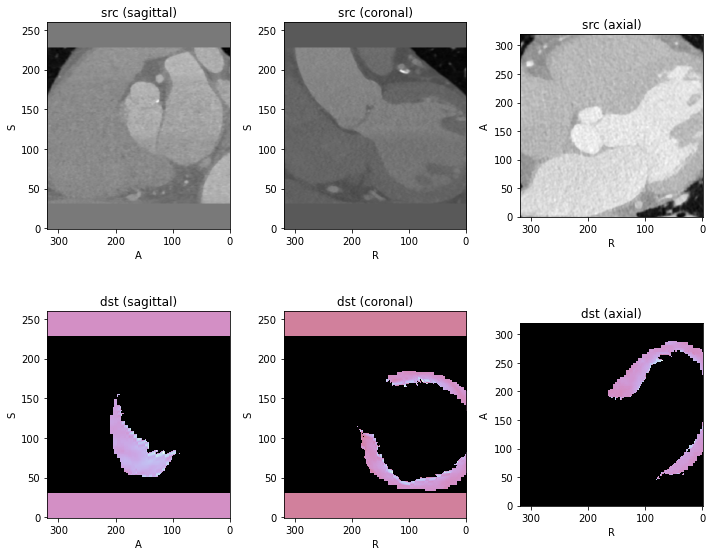

In [7]:
sys.path.append('../external_lib/torchio')

import torchio as tio


image_shape = [320,320,260]
# anisotropy
default_transform = tio.Compose([
            tio.RandomAnisotropy(downsampling=(1,2),scalars_only=False, p=0.9999),              # make images look anisotropic 25% of times
            tio.CropOrPad((image_shape[0], image_shape[1], image_shape[2])),
        ]) 

ds = GAN_COMMON_DS(data_root, 'cropped_cta.nii.gz', 'cropped_mbf.nii.gz', [192,320,320], default_transform)
dataloader = DataLoader(ds, batch_size=2)

for i in range(2):
    print(i)
    one_subject = ds[i]
    one_subject.plot(figsize=(10,10))
#     break

---
### 3. 对数据进行中心crop和pad
这是为了保证进行完数据增强之后数据输出的大小统一，以便后续程序应用

0


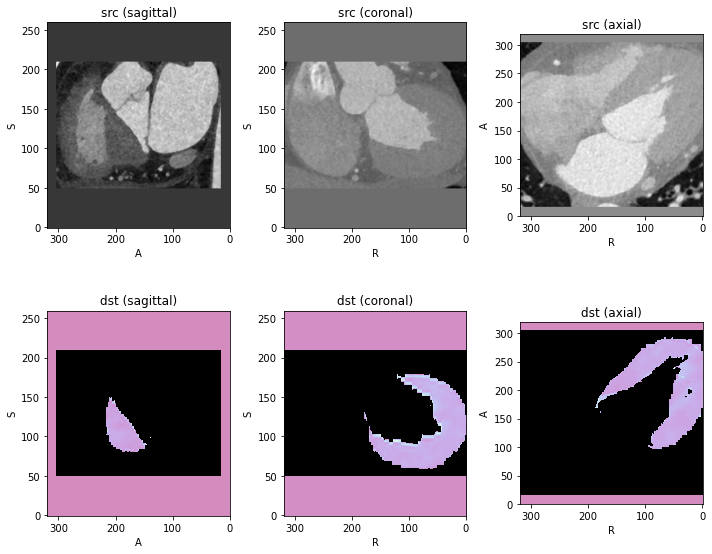

1


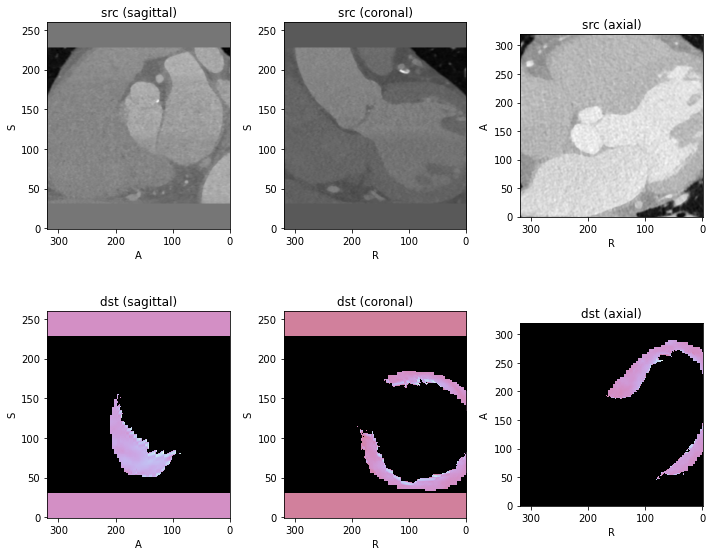

In [10]:
sys.path.append('../external_lib/torchio')

import torchio as tio


image_shape = [320,320,260]
# anisotropy
default_transform = tio.Compose([
            tio.CropOrPad((image_shape[0], image_shape[1], image_shape[2]))
        ]) 

ds = GAN_COMMON_DS(data_root, 'cropped_cta.nii.gz', 'cropped_mbf.nii.gz', [192,320,320], default_transform)
dataloader = DataLoader(ds, batch_size=2)

for i in range(2):
    print(i)
    one_subject = ds[i]
    one_subject.plot(figsize=(10,10))
#     break

---
### 4. 对数据进行随机crop和pad
只对数据进行中心crop和pad，每例数据都是相同的范围，数据多样性不足，这里可以引入随机的crop和pad，如下的例子，只针对一例数据进行展示，可以随机crop出不同的视图

0


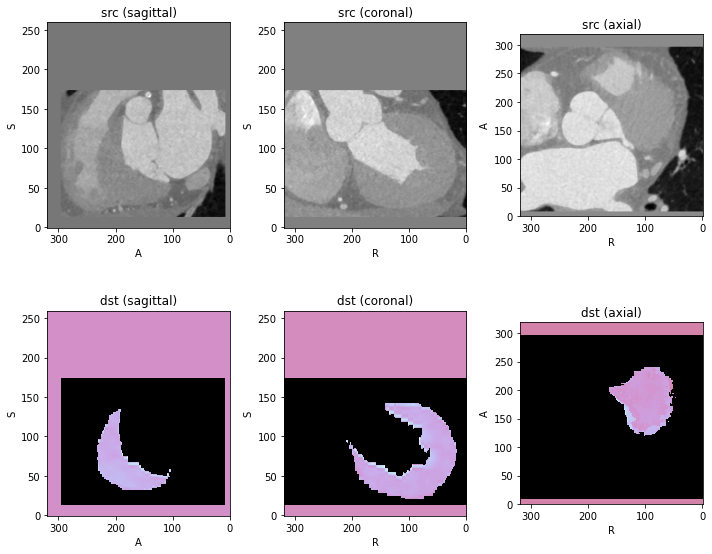

1


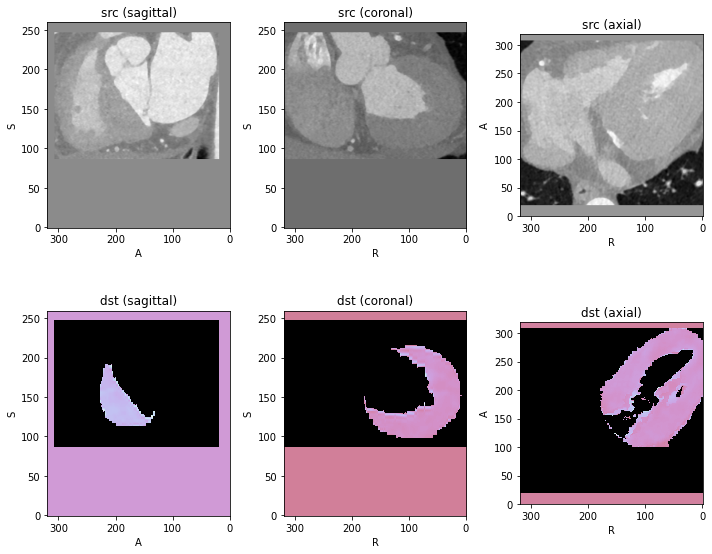

In [11]:
sys.path.append('../external_lib/torchio')

import torchio as tio


image_shape = [320,320,260]
# anisotropy
default_transform = tio.Compose([
            tio.RandomCropOrPad((image_shape[0], image_shape[1], image_shape[2]))
        ]) 

ds = GAN_COMMON_DS(data_root, 'cropped_cta.nii.gz', 'cropped_mbf.nii.gz', [192,320,320], default_transform)
dataloader = DataLoader(ds, batch_size=2)

for i in range(2):
    print(i)
    one_subject = ds[0]
    one_subject.plot(figsize=(10,10))
#     break

tio.RandomCropOrPad((image_shape[0], image_shape[1], image_shape[2]))

### 4. 对数据进行模糊


Blur an image using a random-sized Gaussian filter.

Args:

std: Tuple :math: $(a_1, b_1, a_2, b_2, a_3, b_3)$ representing the
    ranges (in mm) of the standard deviations
    :math:$(\sigma_1, \sigma_2, \sigma_3)$ of the Gaussian kernels used
    to blur the image along each axis, where
    :math:$\sigma_i \sim \mathcal{U}(a_i, b_i)$.
    If two values :math:$(a, b)$ are provided,
    then :math:$\sigma_i \sim \mathcal{U}(a, b)$.
    If only one value :math:$x$ is provided,
    then :math:$\sigma_i \sim \mathcal{U}(0, x)$.
    If three values :math:$(x_1, x_2, x_3)$ are provided,
    then :math:$\sigma_i \sim \mathcal{U}(0, x_i)$.
        
**kwargs: See :class:`~torchio.transforms.Transform` for additional
    keyword arguments.
    

0


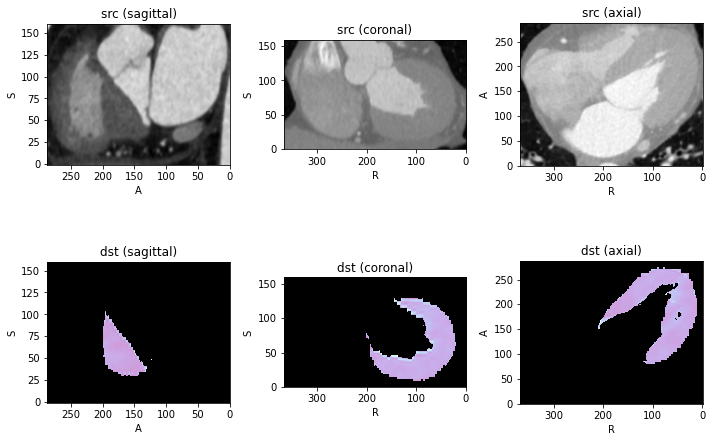

1


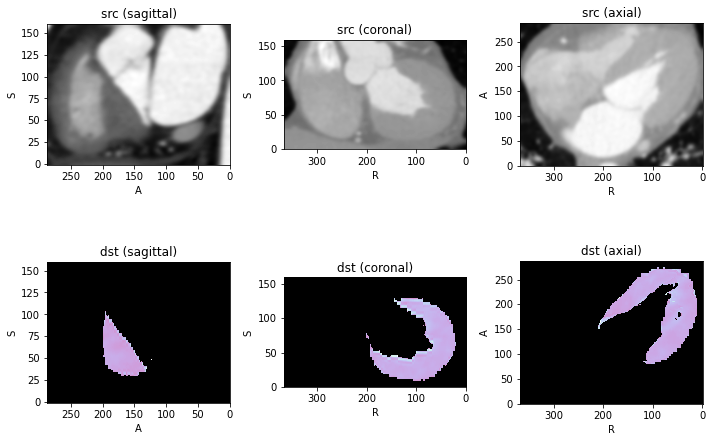

In [14]:
sys.path.append('../external_lib/torchio')

import torchio as tio


image_shape = [320,320,260]
# anisotropy
default_transform = tio.Compose([
            tio.RandomBlur()
        ]) 

ds = GAN_COMMON_DS(data_root, 'cropped_cta.nii.gz', 'cropped_mbf.nii.gz', [192,320,320], default_transform)
dataloader = DataLoader(ds, batch_size=2)

for i in range(2):
    print(i)
    one_subject = ds[0]
    one_subject.plot(figsize=(10,10))

### 5. 对数据进行噪声

Add Gaussian noise with random parameters.

Add noise sampled from a normal distribution with random parameters.

Args:

mean: Mean :math:$\mu$ of the Gaussian distribution
    from which the noise is sampled.
    If two values :math:$(a, b)$ are provided,
    then :math:$\mu \sim \mathcal{U}(a, b)$.
    If only one value :math:`d` is provided,
    :math:$\mu \sim \mathcal{U}(-d, d)$.
    
std: Standard deviation :math:$\sigma$ of the Gaussian distribution
    from which the noise is sampled.
    If two values :math:$(a, b)$ are provided,
    then :math:$\sigma \sim \mathcal{U}(a, b)$.
    If only one value :math:`d` is provided,
    :math:$\sigma \sim \mathcal{U}(0, d)$.
    
**kwargs: See :class:`~torchio.transforms.Transform` for additional
    keyword arguments.

0


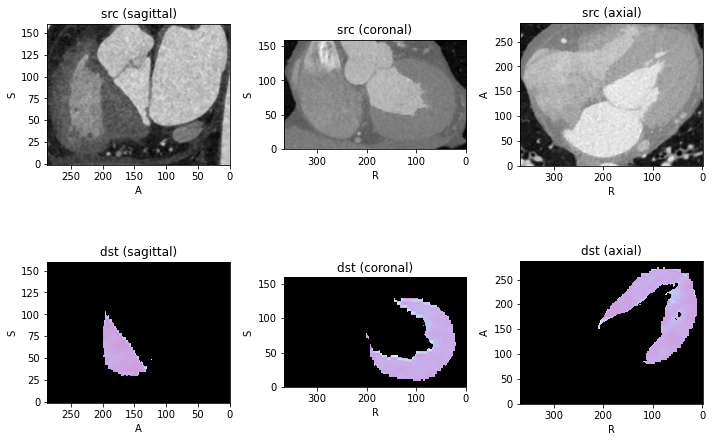

1


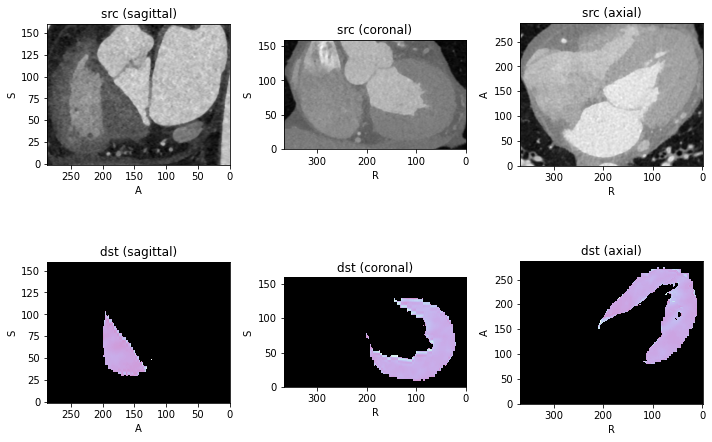

In [15]:
sys.path.append('../external_lib/torchio')

import torchio as tio


image_shape = [320,320,260]
# anisotropy
default_transform = tio.Compose([
            tio.RandomNoise()
        ]) 

ds = GAN_COMMON_DS(data_root, 'cropped_cta.nii.gz', 'cropped_mbf.nii.gz', [192,320,320], default_transform)
dataloader = DataLoader(ds, batch_size=2)

for i in range(2):
    print(i)
    one_subject = ds[0]
    one_subject.plot(figsize=(10,10))